# NFL Big Data Bowl 2021
## Sam Weinberg

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ipywidgets import interact, fixed

%matplotlib inline
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

from scipy.stats import multivariate_normal as mvn

import warnings
warnings.filterwarnings('ignore')

cur_dir = 'C:\\Users\\Sam\\Documents\\Projects\\NFL Big Data Bowl 2021\\nfl-big-data-bowl-2021'

games2021 = pd.read_csv(cur_dir + '\\games.csv')
train2021 = pd.read_csv(cur_dir + '\\week11.csv')

### Visualize Plays Data

In [2]:
train2021.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-11-16T01:24:15.799Z,77.97,18.61,0.00,0.00,0.00,109.88,289.98,None,497236.0,Jimmy Graham,80.0,TE,1,away,2018111500,90,right,CROSS
1,2018-11-16T01:24:15.799Z,79.41,23.71,0.00,0.00,0.00,90.31,159.68,None,2506363.0,Aaron Rodgers,12.0,QB,1,away,2018111500,90,right,NaN
2,2018-11-16T01:24:15.799Z,85.05,22.71,0.00,0.00,0.00,288.53,141.92,None,2532966.0,Bobby Wagner,54.0,MLB,1,home,2018111500,90,right,NaN
3,2018-11-16T01:24:15.799Z,84.81,17.84,0.01,0.01,0.01,283.13,295.48,None,2539243.0,Bradley McDougald,30.0,SS,1,home,2018111500,90,right,NaN
4,2018-11-16T01:24:15.799Z,85.35,27.05,0.00,0.00,0.00,251.12,350.19,None,2540140.0,Barkevious Mingo,51.0,OLB,1,home,2018111500,90,right,NaN


### Make a Field

Code to create field for visualizations from Rob Mulla (https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position).

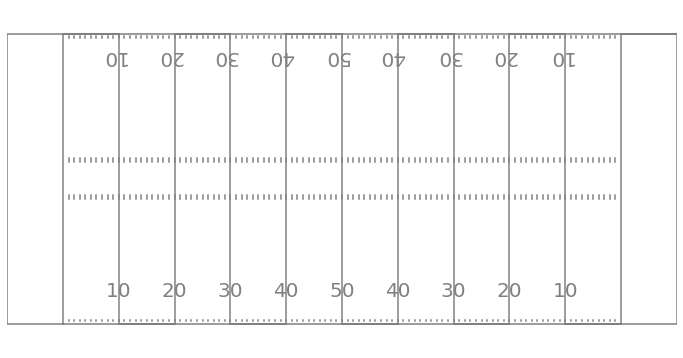

In [3]:
def create_football_field(fig,
                          ax,
                          linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          fifty_is_los=False):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='gray', facecolor='white', zorder=0)

    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='grey')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='grey',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='grey',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='grey')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='grey', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='grey')
        ax.plot([x, x], [53.0, 52.5], color='grey')
        ax.plot([x, x], [22.91, 23.57], color='grey')
        ax.plot([x, x], [29.73, 30.39], color='grey')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='blue')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
    return fig, ax

figsize=(12, 6.33)
fig, ax = plt.subplots(1, figsize=figsize)
create_football_field(fig=fig,ax=ax)
plt.show()

### Work With Sample Play



In [4]:
# Choose play
play_id = 5577
game_id = 2018111900
example_play = train2021.query('gameId == @game_id and playId == @play_id')

# Lets add a new column that includes the distance from each player to the ball (for later use)

example_play_home = train2021.query('gameId == @game_id and playId == @play_id and team == "home"')
example_play_away = train2021.query('gameId == @game_id and playId == @play_id and team == "away"')
example_play_ball = train2021.query('gameId == @game_id and playId == @play_id and team == "football"')


In [5]:
# Get team colours
team_colours = pd.read_csv("https://raw.githubusercontent.com/asonty/ngs_highlights/master/utils/data/nfl_team_colors.tsv", sep = '\t')
team_colours.head()

,teams,color1,color1_family,color2
0,ARI,#97233F,red,#000000
1,ATL,#a71930,red,#000000
2,BAL,#241773,blue,#000000
3,BUF,#00338D,blue,#C60C30
4,CAR,#C60C30,light_blue,#101820


In [6]:
home_abbr = games2021[games2021.gameId == game_id].homeTeamAbbr.values[0]
away_abbr = games2021[games2021.gameId == game_id].visitorTeamAbbr.values[0]

home_colour1 = team_colours[team_colours.teams == home_abbr].color1
home_colour2 = team_colours[team_colours.teams == home_abbr].color2

away_colour1 = team_colours[team_colours.teams == away_abbr].color1
away_colour2 = team_colours[team_colours.teams == away_abbr].color2

No handles with labels found to put in legend.


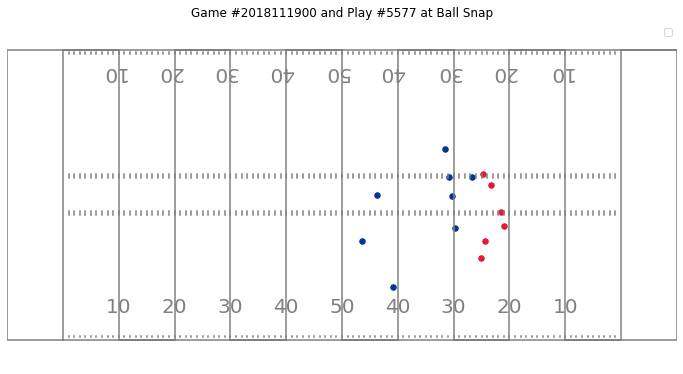

In [7]:
# Plot players at ball snap
figsize=(12, 6.33)
fig, ax = plt.subplots(1, figsize=figsize)
create_football_field(fig, ax)
example_play_home.query('event == "ball_snap"').plot(x = 'x', y = 'y', kind = 'scatter', ax = ax, color = home_colour1, s = 30, legend = 'Away')
example_play_away.query('event == "ball_snap"').plot(x = 'x', y = 'y', kind = 'scatter', ax = ax, color = away_colour1, s = 30, legend = 'Home')
plt.title('Game #{} and Play #{} at Ball Snap'.format(game_id, play_id))
plt.legend()
plt.show()

No handles with labels found to put in legend.


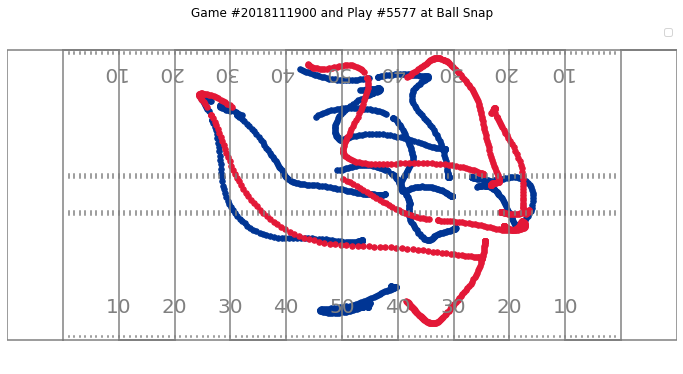

In [8]:
# Plot of overall play routes
figsize=(12, 6.33)
fig, ax = plt.subplots(1, figsize=figsize)
create_football_field(fig,ax)
example_play_home.plot(x = 'x', y = 'y', kind = 'scatter', ax = ax, color = home_colour1, s = 30, legend = 'Away')
example_play_away.plot(x = 'x', y = 'y', kind = 'scatter', ax = ax, color = away_colour1, s = 30, legend = 'Home')
plt.title('Game #{} and Play #{} at Ball Snap'.format(game_id, play_id))
plt.legend()
plt.show()

### Create animation of play

Here we start with Andika Rachman's code for animating player position.

In [9]:
# Create animation of play


def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
def animate_player_movement(weekNumber, playId, gameId):
    weekData = pd.read_csv(cur_dir + '/week' + str(weekNumber) + '.csv')
    playData = pd.read_csv(cur_dir + '/plays.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    figsize=(12, 6.33)
    fig, ax = plt.subplots(1, figsize=figsize)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        create_football_field(fig,ax,highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)

        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

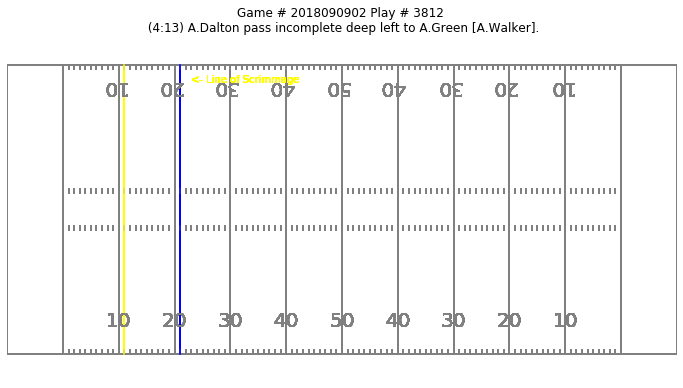

In [10]:
# Animate our example play
anim = animate_player_movement(1, 3812, 2018090902)

writer = FFMpegWriter(fps=10)
anim.save(cur_dir + '\\animation_notrail.mp4', writer=writer)

In [11]:
Video(cur_dir + '\\animation_notrail.mp4', embed=True)

### Field Control Model

Now that we have the ability to visualize plays, we will begin implementing the field control model. At each instance, we need to compute each player's radius of influence as described in "Wide Open Spaces: A statistical technique for measuring space creation in professional soccer". Let's visualize the dataset for our sample play and do some preprocessing to extract some features that we will require.

In [12]:
df = example_play_home
df.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
930470,2018-11-20T04:57:48.000Z,78.45,35.05,0.09,0.28,0.01,156.33,52.58,None,1037374.0,Sam Shields,37.0,CB,1,home,2018111900,5577,left,NaN
930473,2018-11-20T04:57:48.000Z,67.72,26.70,1.49,0.43,0.15,113.66,269.62,None,2543492.0,Lamarcus Joyner,20.0,FS,1,home,2018111900,5577,left,NaN
930474,2018-11-20T04:57:48.000Z,68.87,9.80,0.40,0.17,0.04,34.73,189.37,None,2552488.0,Marcus Peters,22.0,CB,1,home,2018111900,5577,left,NaN
930476,2018-11-20T04:57:48.000Z,79.16,29.92,0.04,0.04,0.01,98.35,229.60,None,2553536.0,Troy Hill,32.0,CB,1,home,2018111900,5577,left,NaN
930479,2018-11-20T04:57:48.000Z,80.32,20.47,0.01,0.01,0.01,84.97,250.77,None,2556277.0,Marqui Christian,41.0,SS,1,home,2018111900,5577,left,NaN


Note player position is given in cartesian coordinates, but velocities are given in polar. Lets convert to cartesian, similar to dx_dy_arrow function previously. The coordinate system implies that the x-direction velocity requires the sine of the direction angle, and y-direction requires cosine.

In [13]:
def polar_to_cartesian(df):
    dir_rad = radians(df.dir)
    df['v_x'] = np.sin(dir_rad)*df.s
    df['v_y'] = np.cos(dir_rad)*df.s
    
    try:
        df['v_dir'] = np.round(np.where(df.v_x == 0, 0, np.arctan(df.v_y/df.v_x)),6)
    except ZeroDivisionError:
        pass
        
    
    return df
    
df = df.apply(polar_to_cartesian, axis=1)
df.head()

,a,dir,dis,displayName,event,frameId,gameId,jerseyNumber,nflId,o,playDirection,playId,position,route,s,team,time,v_dir,v_x,v_y,x,y
930470,0.28,52.58,0.01,Sam Shields,None,1,2018111900,37.0,1037374.0,156.33,left,5577,CB,NaN,0.09,home,2018-11-20T04:57:48.000Z,0.653102,0.071478,0.054689,78.45,35.05
930473,0.43,269.62,0.15,Lamarcus Joyner,None,1,2018111900,20.0,2543492.0,113.66,left,5577,FS,NaN,1.49,home,2018-11-20T04:57:48.000Z,0.006632,-1.489967,-0.009882,67.72,26.70
930474,0.17,189.37,0.04,Marcus Peters,None,1,2018111900,22.0,2552488.0,34.73,left,5577,CB,NaN,0.40,home,2018-11-20T04:57:48.000Z,1.407259,-0.065124,-0.394663,68.87,9.80
930476,0.04,229.60,0.01,Troy Hill,None,1,2018111900,32.0,2553536.0,98.35,left,5577,CB,NaN,0.04,home,2018-11-20T04:57:48.000Z,0.705113,-0.030462,-0.025925,79.16,29.92
930479,0.01,250.77,0.01,Marqui Christian,None,1,2018111900,41.0,2556277.0,84.97,left,5577,SS,NaN,0.01,home,2018-11-20T04:57:48.000Z,0.335627,-0.009442,-0.003294,80.32,20.47


Let's extract the distance from each player to the ball, which will be used to calculate their influence radius.

In [14]:
# Ball location
example_play_ball.head()    

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
930484,2018-11-20T04:57:48.000Z,84.26,23.74,0.0,0.0,0.00,NaN,NaN,None,NaN,Football,NaN,NaN,1,football,2018111900,5577,left,NaN
930499,2018-11-20T04:57:48.099Z,84.26,23.74,0.0,0.0,0.00,NaN,NaN,None,NaN,Football,NaN,NaN,2,football,2018111900,5577,left,NaN
930514,2018-11-20T04:57:48.200Z,84.26,23.74,0.0,0.0,0.00,NaN,NaN,None,NaN,Football,NaN,NaN,3,football,2018111900,5577,left,NaN
930529,2018-11-20T04:57:48.299Z,84.25,23.74,0.0,0.0,0.01,NaN,NaN,None,NaN,Football,NaN,NaN,4,football,2018111900,5577,left,NaN
930544,2018-11-20T04:57:48.400Z,84.25,23.74,0.0,0.0,0.00,NaN,NaN,None,NaN,Football,NaN,NaN,5,football,2018111900,5577,left,NaN


In [15]:
# Add columns for ball location    

df['ball_x'] = np.zeros(example_play_home.shape[0])  
df['ball_y'] = np.zeros(example_play_home.shape[0])   

for frame in example_play_ball.frameId:
    ball_x = example_play_ball.query('frameId == ' + str(frame))['x'].values[0]
    ball_y = example_play_ball.query('frameId == ' + str(frame))['y'].values[0]
    df.loc[df['frameId'] == frame,'ball_x'] = ball_x
    df.loc[df['frameId'] == frame,'ball_y'] = ball_y
    
# Calculate Euclidean distance from each player to the ball (used to define influence radius R_i)
df['ball_dist'] = np.sqrt((df.ball_x - df.x)**2 + (df.ball_y - df.y)**2)

Let's find each player speed ratio compared to some maximum speed (13m/s used in paper).

In [16]:
# Calculate each player's max speed ratio
s_max = 13 # 13m/s used in paper

df['s_rat'] = np.round(df.s**2/s_max**2, 6)

Let's propogate each player's position 0.5 seconds into the future.

In [17]:
# Calculate each player's 'next' mean position
df['x_next'] = df['x'] + 0.5*df['v_x']
df['y_next'] = df['y'] + 0.5*df['v_y']

Now we'll calculate each player's influence radius R_i using their distance to the ball. The function isn't explicitly provided in the paper, but resembles Figure 9. The function has a minimum value of 4 at a distance from the ball of zero, and a maximum threshold value of 10 a distance of approximately 18m from the ball. The function has been estimated by Will Thompson (https://colab.research.google.com/drive/1V75UgfJEfCWgbfxnG4OuB1WpvqahUJPU?pli=1) as follows.

In [18]:
# Calculate influence radius R_i
df['R_i'] = 4 + df.ball_dist**3/(18**3/6)
df.loc[df['R_i'] > 10, 'R_i'] = 10

Now that we have completed our preprocessing, we can start compiling our influence model. Each player's influence is modeled as a bivariate Gaussian distribution. The distribution is stretched based on their speed and direction of motion.

In [19]:
# Set up some functions to calculate rotation matrix and scaling matrix

def calculate_rotation_matrix(v_dir):
    return np.array([[np.cos(v_dir), -np.sin(v_dir)], [np.sin(v_dir), np.cos(v_dir)]])

def calculate_scaling_matrix(R_i, S_rat):
    s_x = R_i + R_i*S_rat/2
    s_y = R_i - R_i*S_rat/2    
    return np.array([[s_x, 0],[0, s_y]])

def calculate_cov_matrix(v_dir, R_i, S_rat):
    R = calculate_rotation_matrix(v_dir)
    S = calculate_scaling_matrix(R_i, S_rat)
    return np.linalg.solve(R, np.matmul(R,S,S))

In [20]:
x_grid = np.linspace(0,120,200)
y_grid = np.linspace(0,53.3,200)
xx,yy = np.meshgrid(x_grid,y_grid)
mu = np.array([30, 40])
sigma = np.array([[1,0.0002],[0.0002,1]])

mvn.pdf([20,30],mu,sigma)

6.040266534022616e-45

In [21]:
# Calculate influence function using mvn
def calculate_player_influence(location, x, y, mu, sigma):
    return mvn.pdf(location, mu, sigma) / mvn.pdf([x, y], mu, sigma)

We can now calculate the influence of a player at a given time. Let's add this to the animation function.

In [24]:
# Create animation of play


def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
    
def polar_to_cartesian(df):
    dir_rad = radians(df.dir)
    df['v_x'] = np.sin(dir_rad)*df.s
    df['v_y'] = np.cos(dir_rad)*df.s
    
    try:
        df['v_dir'] = np.round(np.where(df.v_x == 0, 0, np.arctan(df.v_y/df.v_x)),6)
    except ZeroDivisionError:
        pass
            
    return df

def data_preprocessing(df, df_football):
    df_new = df.apply(polar_to_cartesian, axis=1)
    
    # Add columns for ball location    
    df_new['ball_x'] = np.zeros(df_new.shape[0])  
    df_new['ball_y'] = np.zeros(df_new.shape[0])   

    for frame in df_football.frameId:
        ball_x = df_football.query('frameId == ' + str(frame))['x'].values[0]
        ball_y = df_football.query('frameId == ' + str(frame))['y'].values[0]
        df_new.loc[df_new['frameId'] == frame,'ball_x'] = ball_x
        df_new.loc[df_new['frameId'] == frame,'ball_y'] = ball_y

    # Calculate Euclidean distance from each player to the ball (used to define influence radius R_i)
    df_new['ball_dist'] = np.sqrt((df_new.ball_x - df_new.x)**2 + (df_new.ball_y - df_new.y)**2)
    
    
    # Calculate each player's max speed ratio
    s_max = 13 # 13m/s used in paper
    df_new['s_rat'] = np.round(df_new.s**2/s_max**2, 6)
    
    # Calculate each player's 'next' mean position
    df_new['x_next'] = df_new['x'] + 0.5*df_new['v_x']
    df_new['y_next'] = df_new['y'] + 0.5*df_new['v_y']
    
    # Calculate influence radius R_i
    df_new['R_i'] = 4 + df_new.ball_dist**3/(18**3/6)
    df_new.loc[df_new['R_i'] > 18, 'R_i'] = 10
    
    return df_new
    
    
def animate_player_movement(weekNumber, playId, gameId):
    weekData = pd.read_csv(cur_dir + '/week' + str(weekNumber) + '.csv')
    playData = pd.read_csv(cur_dir + '/plays.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
        
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
        
        
    # Data preprocessing
    playHome = playHome.apply(polar_to_cartesian, axis=1)
    playAway = playAway.apply(polar_to_cartesian, axis=1)
    
    playHome = data_preprocessing(playHome, playFootball)
    playAway = data_preprocessing(playAway, playFootball)
    
    figsize=(12, 6.33)
    fig, ax = plt.subplots(1, figsize=figsize)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()

    
    def update_animation(time):
        ax.clear()
        create_football_field(fig, ax, highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
        ax.set_title(f'Game # {gameId} Play # {playId} \n {playDesc}')
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        ax.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white')
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            ax.text(x, y, int(num), va='center', ha='center', color='black', size='medium')
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            ax.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full')
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            ax.arrow(x, y, dx, dy, color='black', width=0.25, shape='full')
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        ax.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white')
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            ax.text(x, y, int(num), va='center', ha='center', color='white', size='medium')
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            ax.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full')
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            ax.arrow(x, y, dx, dy, color='black', width=0.25, shape='full')
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        ax.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team'])
               
        
        # UPDATE FIELD CONTROL
        
        # Away + Home players' next location estimate
        awayXnext = playAway.query('time == ' + str(time))['x_next']
        awayYnext = playAway.query('time == ' + str(time))['y_next']

        homeXnext = playHome.query('time == ' + str(time))['x_next']
        homeYnext = playHome.query('time == ' + str(time))['y_next']
        
        
        # Away + Home players' direction for rotation matrix function
        awayVdir = playAway.query('time == ' + str(time))['v_dir']
        homeVdir = playHome.query('time == ' + str(time))['v_dir']
        
        # Away + Home players' speed ratio/influence radius for scaling matrix function
        awaySrat = playAway.query('time == ' + str(time))['s_rat']
        awayRi = playAway.query('time == ' + str(time))['R_i']

        homeSrat = playHome.query('time == ' + str(time))['s_rat']
        homeRi = playHome.query('time == ' + str(time))['R_i']
        
        # Define grid for field locations
        x_grid = np.linspace(0,120,500)
        y_grid = np.linspace(0,53.3,500)
        xx,yy = np.meshgrid(x_grid,y_grid)
        
        # Initialize total influence functions
        influence_home = np.zeros(250000)
        influence_away = np.zeros(250000)
        
        # Calculate total field influence for Away + Home
        for x, y, x_next, y_next, v_dir, s_rat, r_i in zip(awayX, awayY, awayXnext, awayYnext, awayVdir, awaySrat, awayRi):
            awayMu = np.array([x_next, y_next])
            awaySigma = calculate_cov_matrix(v_dir, r_i, s_rat)
            influence_away += calculate_player_influence(np.c_[xx.flatten(),yy.flatten()], x, y, awayMu, awaySigma)
            
        for x, y, x_next, y_next, v_dir, s_rat, r_i in zip(homeX, homeY, homeXnext, homeYnext, homeVdir, homeSrat, homeRi):
            homeMu = np.array([x_next, y_next])
            homeSigma = calculate_cov_matrix(v_dir, r_i, s_rat)
            influence_home += calculate_player_influence(np.c_[xx.flatten(),yy.flatten()], x, y, homeMu, homeSigma)
            
        influence_away = influence_away.reshape((500,500))
        influence_home = influence_home.reshape((500,500))
        
        # Append overall influence to patch    
        ax.contourf(xx, yy, 1/(1 + np.exp(-influence_away + influence_home)), cmap = 'coolwarm')
        #plt.colorbar(cs, ax = ax)
        
    anim = animation.FuncAnimation(fig, update_animation, np.arange(minTime, maxTime+1), interval = 40, repeat=False)
    
    return anim

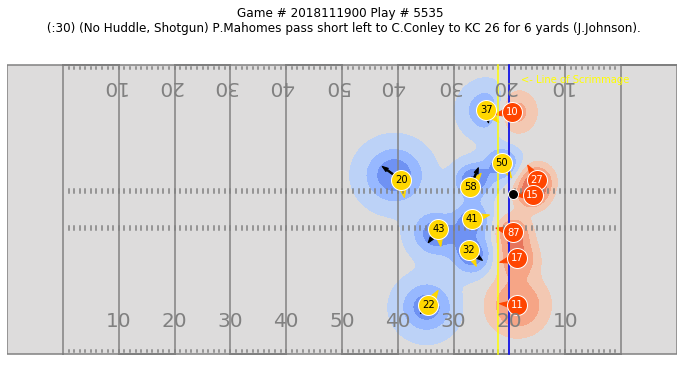

In [51]:
# Animate our example play
week = 11
play = 5535
game = 2018111900 
anim = animate_player_movement(week, play, game)

writer = FFMpegWriter(fps=10)
anim.save(cur_dir + '\\animation_notrail.mp4', writer=writer)

In [52]:
Video(cur_dir + '\\animation_notrail.mp4', embed=True)